# Iterative Optimal Transport for Multimodal Image Registration

In [1]:
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utilis import (
    norm_data, convert_point_to_pixel, # data preprocessing
    canny_edge_detector, edge_points,  # feature point detection
    plot_points_on_image, create_checkerboard, create_overlap_edge # image visualization
    )
from IOT import IOTreg, IOTtrans, create_polynomial_matrix # the proposed IOT method
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load data

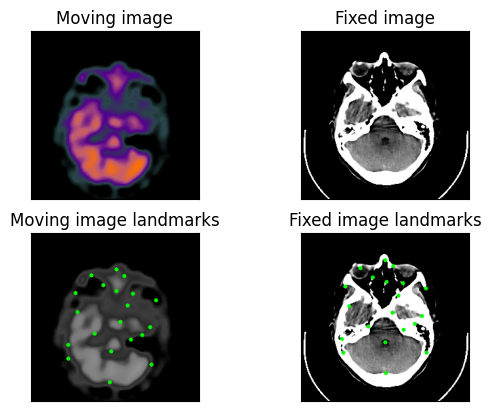

In [2]:
# Image pair
im1 = cv2.imread("example_data/CT.png")
im2 = cv2.imread("example_data/SPECT.png")
img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Ground truth (landmarks with correspondences)
mat_file = scipy.io.loadmat("example_data/SPECT_CT_landmarks.mat")
gt1 = mat_file['Landmarks']['LMmov'][0, 0].astype(np.float32)
gt2 = mat_file['Landmarks']['LMfix'][0, 0].astype(np.float32)
X_test = convert_point_to_pixel(im1, gt1)
Y_test = convert_point_to_pixel(im2, gt2)

# Visualize data
plt.subplot(221)
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Moving image")
plt.subplot(222)
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Fixed image")
plt.subplot(223)
plt.imshow(plot_points_on_image(img1, X_test, radius=3, color=(0, 255, 0)))
plt.xticks([])
plt.yticks([])
plt.title("Moving image landmarks")
plt.subplot(224)
plt.imshow(plot_points_on_image(img2, Y_test, radius=3, color=(0, 255, 0)))
plt.xticks([])
plt.yticks([])
plt.title("Fixed image landmarks")
plt.show()

## Edge extraction

In [3]:
rand_seed = 1028  # random seed
N = 300  # number of selected feature points

# Apply the Canny edge detector
edge1 = canny_edge_detector(img1)
edge2 = canny_edge_detector(img2)

# Select keypoints from edge maps
X = edge_points(edge1, N, rand_seed).astype(np.float32)
Y = edge_points(edge2, N, rand_seed).astype(np.float32)
N1 = X.shape[0]
N2 = Y.shape[0]

# Normalize the feature points 
normalize = True
normal = {'xm': 0, 'ym': 0, 'xscale': 1, 'yscale': 1}
if normalize:
    nX, nY, normal = norm_data(X, Y)
    nX_test = (X_test - normal['xm'])/normal['xscale']
else:
    nX = X.copy()
    nY = Y.copy()
    nX_test = X_test.copy()

## Iterative optimal transport for image registration

In [4]:
degree = 1  # degree of polynomials
reg = 1e-2  # regularization parameter
reg_m = 2e-2  # unbalanced relaxation parameter

# Implement the IOT method
T_iot = IOTreg(nX, nY, degree=degree, reg_m=reg_m, lambda_=reg)

# Apply the transformation on moving image landmarks
Viot_test = create_polynomial_matrix(nX_test, degree) @ T_iot
Viot_test = Viot_test * normal['yscale'] + normal['ym']  

# Compute the errors
def compute_rmse(data1, data2):
    return np.sqrt(np.mean(np.sum((data1 - data2) ** 2, axis=1)))

def compute_me(data1, data2):
    return np.mean(np.sqrt(np.sum((data1 - data2) ** 2, axis=1)))

print("Registration error")
print("RMSE:", compute_rmse(Viot_test, Y_test))
print("ME:", compute_me(Viot_test, Y_test))

Registration error
RMSE: 4.268850810552127
ME: 3.9074897539615767


## Image transformation

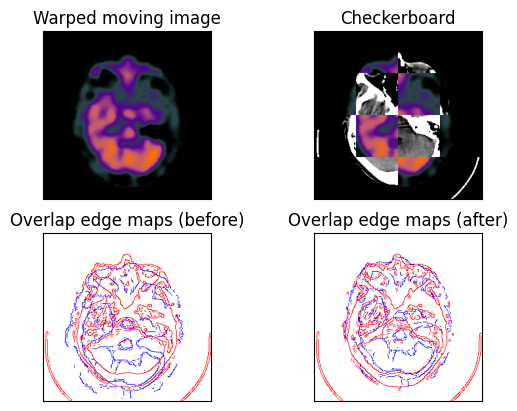

In [5]:
# Apply the transformation on moving image and edge maps
im1_trans = IOTtrans(im1, im2, T_iot, degree, normal)
edge1_trans = IOTtrans(edge1, edge2, T_iot, degree, normal)

# Create the checkerboard
check = create_checkerboard(im1_trans, im2)

# Visualize registratoin results
plt.subplot(221)
plt.imshow(cv2.cvtColor(im1_trans, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Warped moving image")
plt.subplot(222)
plt.imshow(cv2.cvtColor(check, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Checkerboard")
plt.subplot(223)
plt.imshow(create_overlap_edge(edge1, edge2))
plt.xticks([])
plt.yticks([])
plt.title("Overlap edge maps (before)")
plt.subplot(224)
plt.imshow(create_overlap_edge(edge1_trans, edge2))
plt.xticks([])
plt.yticks([])
plt.title("Overlap edge maps (after)")
plt.show()